## Data collection

We use a Kaggle API key to collect the Wine-quality dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henryochiabuto","key":"ce8af37b0718cba3f3046a0b321bc303"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle competitions download -c wine-quality-pred

  0% 0.00/30.7k [00:00<?, ?B/s]
100% 30.7k/30.7k [00:00<00:00, 1.94MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/wine-quality-pred.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [7]:
train_df.shape

(1143, 13)

In [8]:
test_df.shape

(456, 12)

Data is checked for missing values

In [9]:
train_df.isna().sum().sum()

0

In [10]:
train_df.duplicated().sum()

0

We check the distribution of target variables

In [11]:
train_df['quality'].value_counts(dropna=False)

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

On observation on the spread of the target variable (quality), we decide to divide them into 3 classes - 0, 1 & 2.
This should help to improve our multiclass classification algorithm.

In [12]:
mapping = {3:0,
          4:0,
          5:1,
          6:1,
          7:2,
          8:2}

'Quality Rating' column for the mapped target variables

In [13]:
train_df['quality_rating'] = train_df['quality'].map(mapping)


In [14]:
train_df['quality_rating'].value_counts(dropna=False)

1    945
2    159
0     39
Name: quality_rating, dtype: int64

In [15]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id', 'quality_rating'],
      dtype='object')

In [16]:
test_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'Id'],
      dtype='object')

## Data Exploration

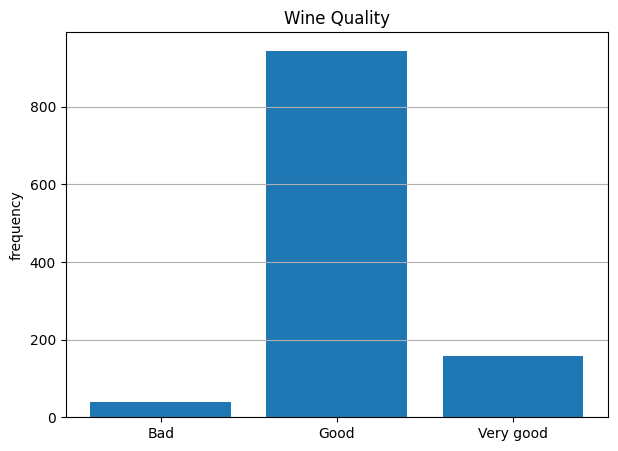

In [17]:
label = ('Bad', 'Good', 'Very good')
freq = train_df['quality_rating'].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(7,5))

plt.bar(label, freq, align='center')
plt.ylabel('frequency')
plt.title('Wine Quality')
plt.grid(axis = 'y')

plt.show()

A Distplot and Boxplot visualization of the independent variables are created


Text(0.5, 0.98, 'Visualization of Numeric Features')

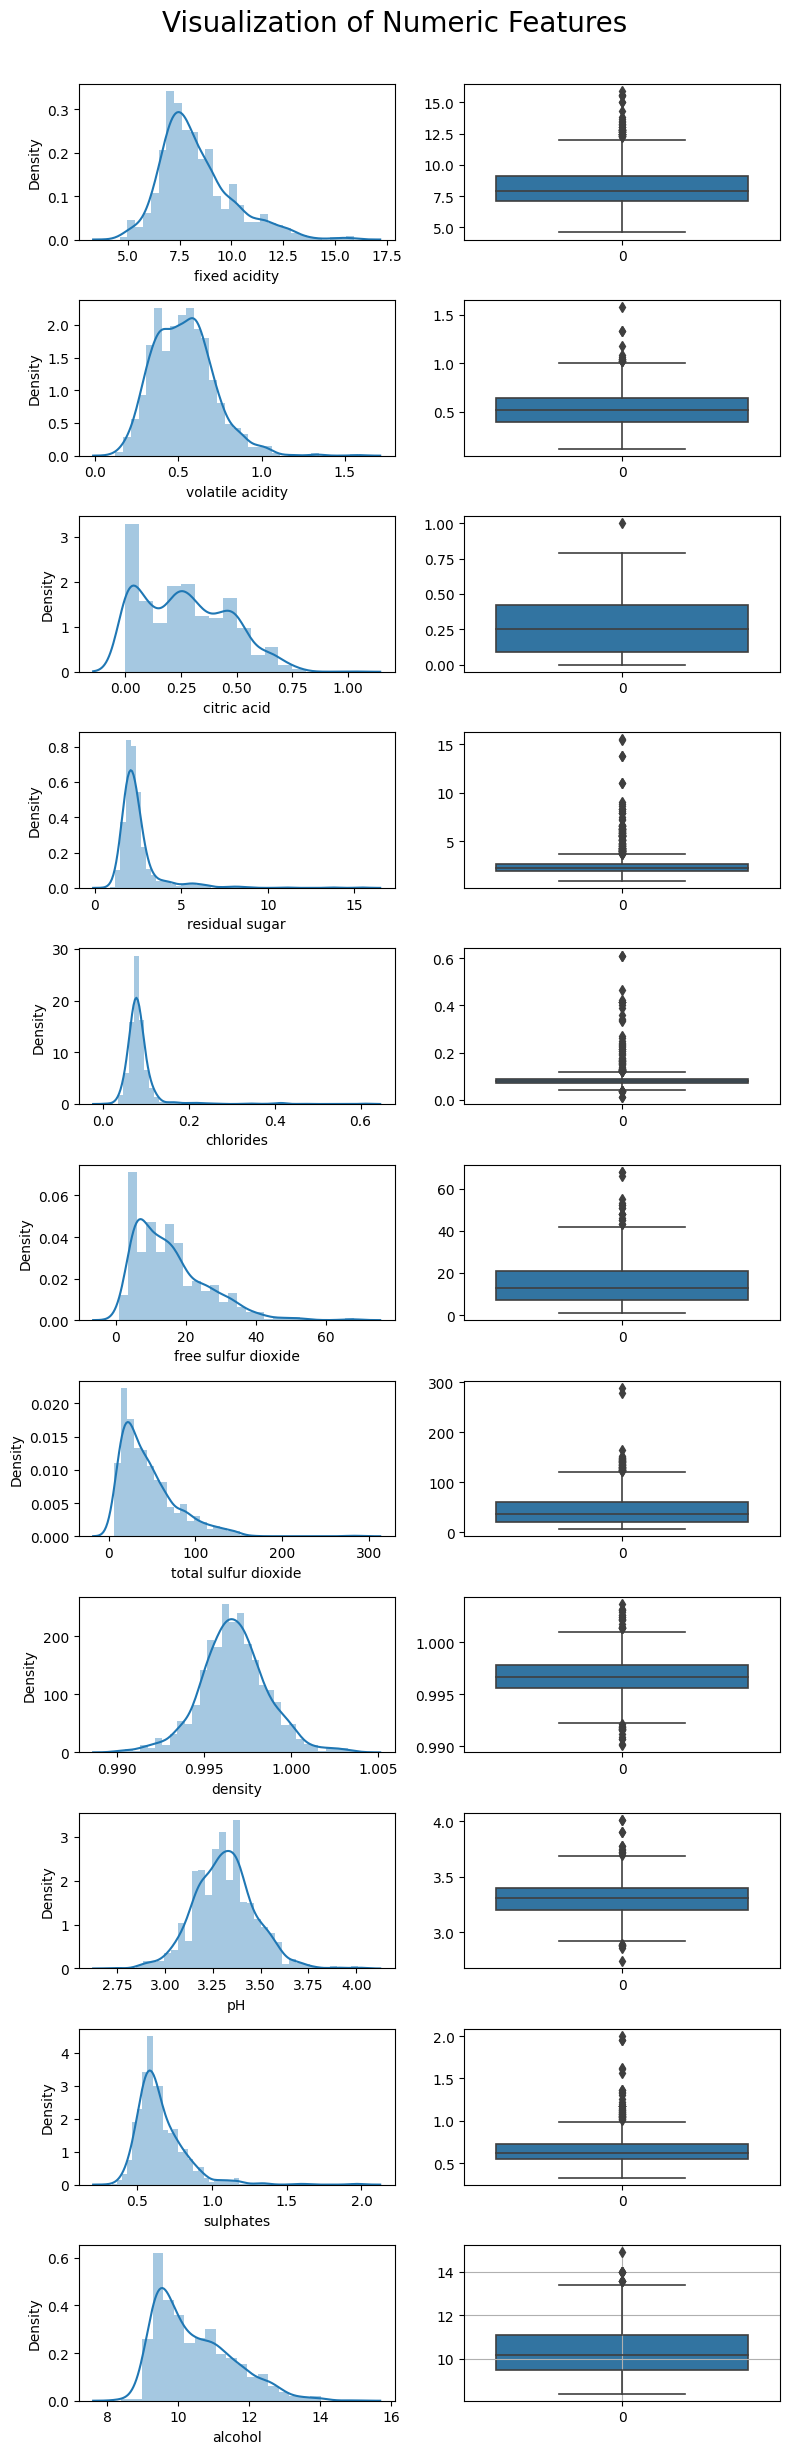

In [18]:
# plot distribution and box plots for numerical variables

import warnings
warnings.filterwarnings('ignore')

fig,ax = plt.subplots(11,2,figsize=(8,25))
for index,i in enumerate(train_df.drop(['quality', 'quality_rating', 'Id'] ,axis = 1).columns):
    sns.distplot(train_df[i],ax=ax[index,0])
    sns.boxplot(train_df[i],ax=ax[index,1], linewidth = 1.2)
    plt.grid()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.suptitle("Visualization of Numeric Features",fontsize=20)


A heatmap of the created to look for correlation between the variables

<Axes: >

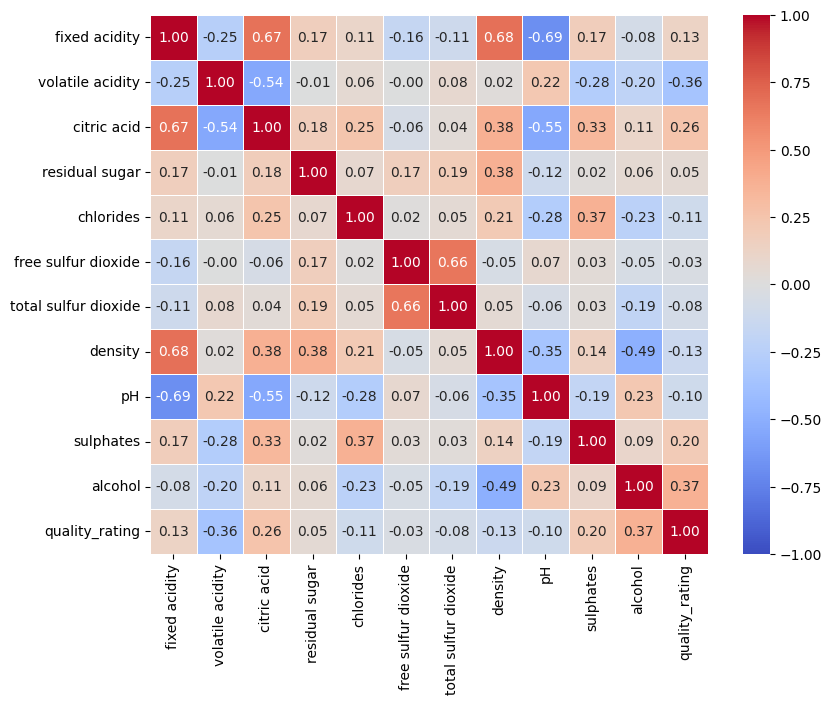

In [19]:
fig = plt.figure(figsize=(9,7), facecolor='white')
sns.heatmap(train_df.drop(['quality', 'Id'], axis = 1).corr(), vmin = -1, annot=True,linewidth=0.5,  annot_kws={"fontsize":10, 'rotation':0} ,fmt = '.2f', cmap = 'coolwarm')

Observation
For each features, the pearson correlation coefficient never:
greater than 0.8
lower than -0.8
Based on that, it can be said that multicolinearity problem does not present in this dataset

Text(0.5, 0.98, 'Visualization of Wine quality vs Numerical Features')

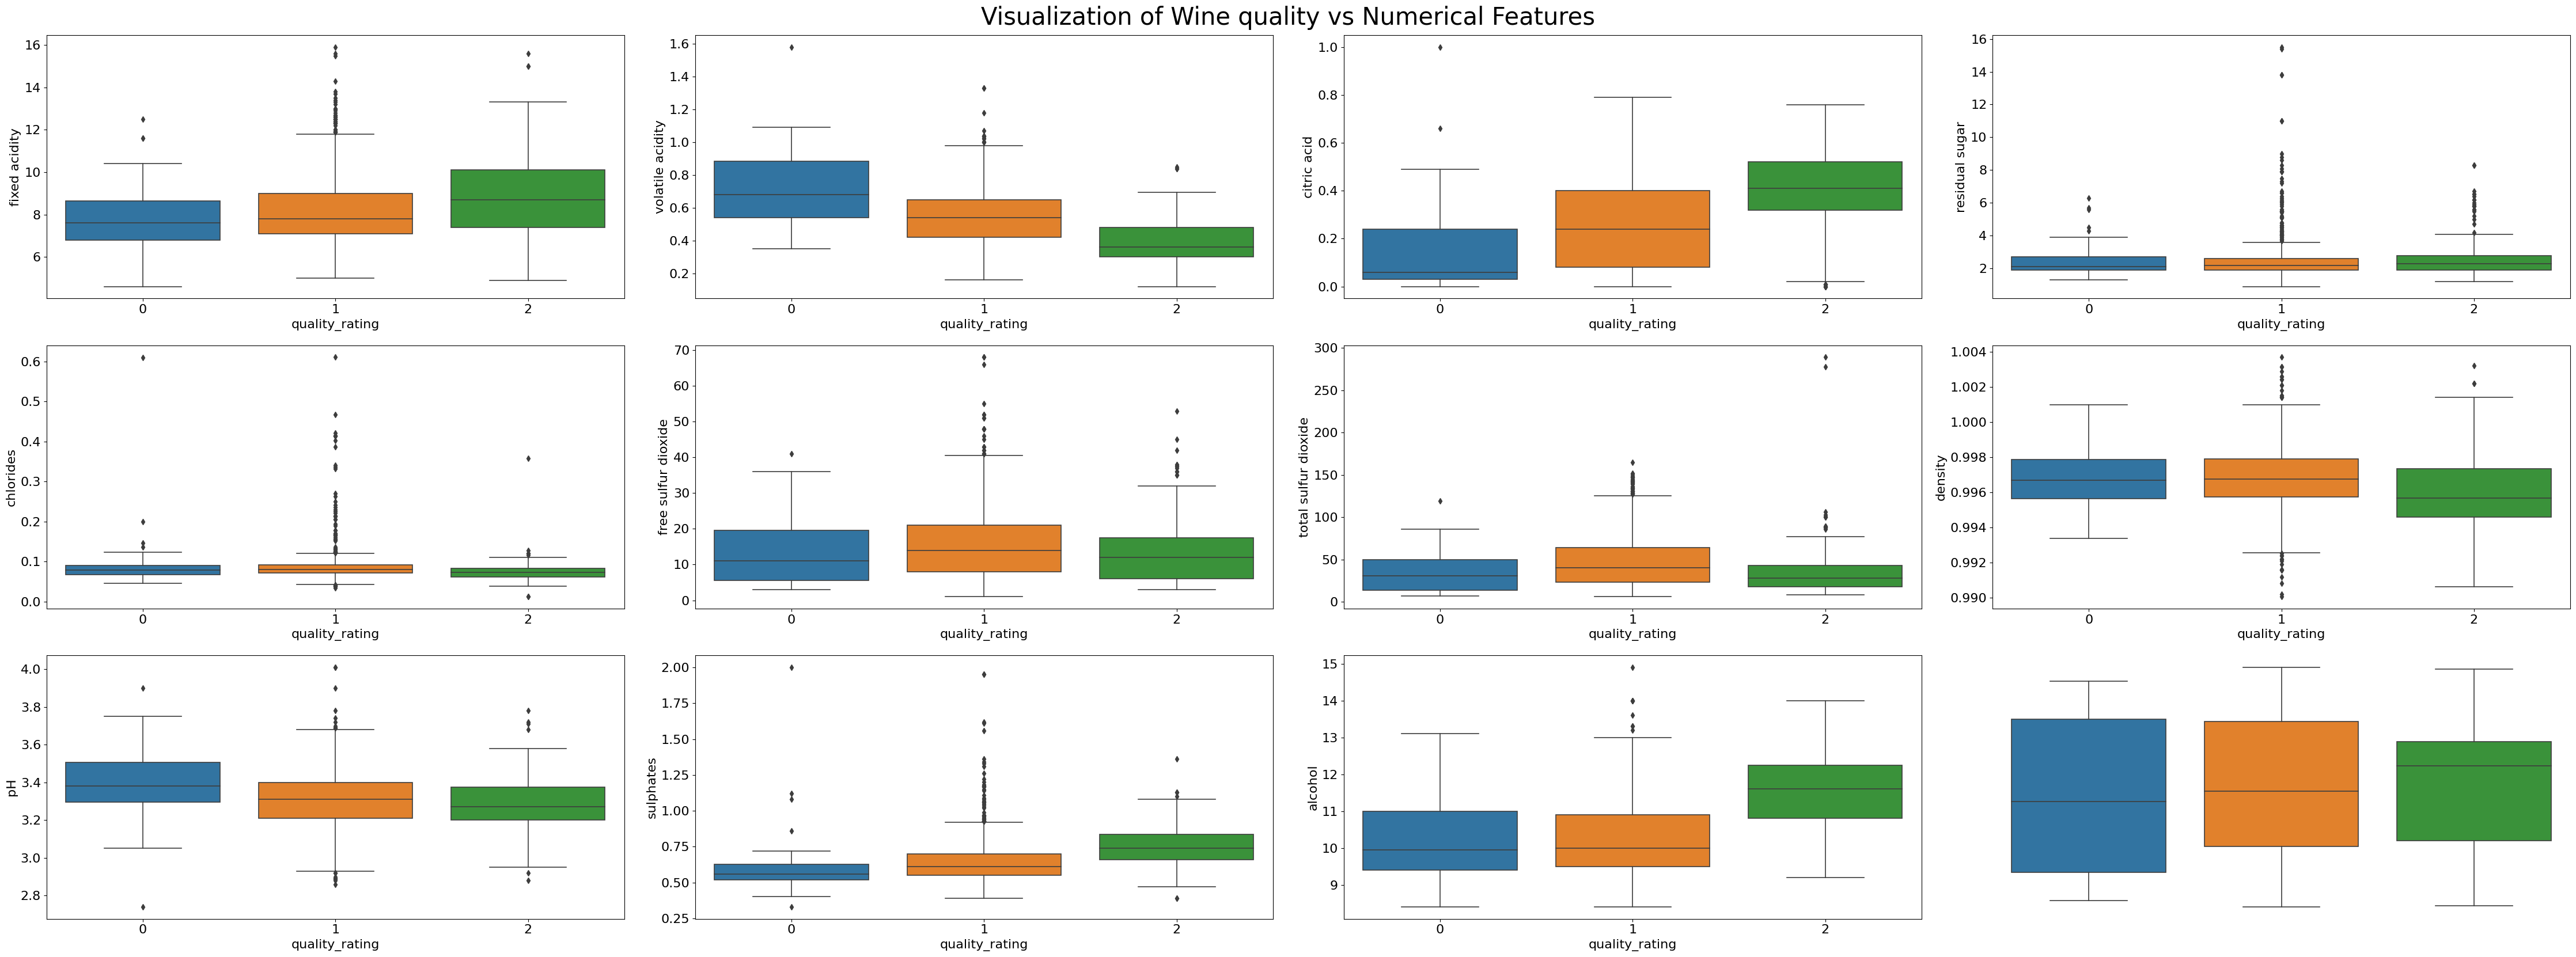

In [20]:
import warnings
import math
import statsmodels.api as sm
import scipy.stats as stats
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = '16'
cols = 4
rows = math.ceil(len(train_df.drop('quality',axis = 1).columns) / cols)

fig,ax = plt.subplots(3,4,figsize=(45,17))
l = 0
for i in range(rows):
    for j in range(cols):
        if len(train_df.drop(['quality_rating', 'quality'], axis = 1).columns) == l:
            break
        else:
            sns.boxplot(y = train_df[train_df.drop(['quality_rating', 'quality'],axis = 1).columns[l]], x = train_df['quality_rating'],ax=ax[i,j], linewidth = 1.2)
        l += 1

ax[2,3].set_axis_off()
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualization of Wine quality vs Numerical Features",fontsize=30)

Form our observation, we can deduce the following:
- Alcohol content in the very good wine is considerably higher than the other classes of wine.
- Citric acid content increases while Volatile acidity content reduces considerably as the wine gets better.

## Feature Engineering and Preprocessing

Moving on, we try to remove the outliers within our dataset

In [21]:
train_df_main = train_df.copy()

for col in train_df_main.drop(['Id', 'quality', 'quality_rating'],axis = 1).columns:
    Q1 = train_df_main[col].quantile(0.25)
    Q3 = train_df_main[col].quantile(0.75)

    IQR = Q3 - Q1
    train_df_main = train_df_main[~(train_df_main[col] < (Q1 - 1.5 * IQR)) & ~(train_df_main[col] > (Q3 + 1.5 * IQR))]


In [22]:
cols = [i for i in train_df_main.columns]
cols.remove('Id')
cols.remove('quality')
cols.remove('quality_rating')

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
X = train_df_main[cols]
y = train_df_main['quality_rating']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Building

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score

Since we are working on a multiclass classification problem we decide to go with RandomForest, DecisionTree, KNearestNeighbor, SVM and GradientBoosting Algorithms


In [27]:
rf = RandomForestClassifier(max_features=5)
rf.fit(X_train_scaled, y_train)
train_preds_rf = rf.predict(X_train_scaled)
test_preds_rf = rf.predict(X_test_scaled)
print("training accuracy:", accuracy_score(train_preds_rf, y_train))
print("testing accuracy:", accuracy_score(test_preds_rf, y_test))

training accuracy: 1.0
testing accuracy: 0.9125


In [28]:
dt = DecisionTreeClassifier(max_depth = 2).fit(X_train_scaled, y_train)
train_preds_dt = dt.predict(X_train_scaled)
test_preds_dt = dt.predict(X_test_scaled)
print("training accuracy:", accuracy_score(train_preds_dt, y_train))
print("testing accuracy:", accuracy_score(test_preds_dt, y_test))

training accuracy: 0.8618524332810047
testing accuracy: 0.84375


In [29]:
knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
train_preds_knn = knn.predict(X_train_scaled)
test_preds_knn = knn.predict(X_test_scaled)
print("training accuracy:", accuracy_score(train_preds_knn, y_train))
print("testing accuracy:", accuracy_score(test_preds_knn, y_test))

training accuracy: 0.8979591836734694
testing accuracy: 0.88125


In [30]:
svm = SVC(decision_function_shape='ovo').fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
train_preds_svm = knn.predict(X_train_scaled)
test_preds_svm = knn.predict(X_test_scaled)
print("training accuracy:", accuracy_score(train_preds_svm, y_train))
print("testing accuracy:", accuracy_score(test_preds_svm, y_test))

training accuracy: 0.8979591836734694
testing accuracy: 0.88125


In [31]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled, y_train)
train_preds_gbc = gbc.predict(X_train_scaled)
test_preds_gbc = gbc.predict(X_test_scaled)
print("training accuracy:", accuracy_score(y_train, train_preds_gbc))
print("testing accuracy:", accuracy_score(y_test, test_preds_gbc))

training accuracy: 0.9937205651491365
testing accuracy: 0.9


### Hyperparameter Tuning

Let us do a bit of hyperparameter tuning for our best performing algorithms

In [ ]:
!pip install optuna

In [33]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Preventing Optuna from logging each step
from sklearn.model_selection import cross_val_score, KFold
import functools
from sklearn.pipeline import make_pipeline

We create functions that help with tuning the RandomForest algorithm parameters

In [34]:
def objective_rf(trial, X, y):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 10),
                          'n_estimators': trial.suggest_int('n_estimators', 50, 700),
                          'random_state': trial.suggest_int('random_state', 0, 0)
                         }
    ct = StandardScaler()
    clf = make_pipeline(ct, RandomForestClassifier(**params))
    scores = cross_val_score(clf, X, y, cv=5)
    return np.mean(scores)

We create functions that help with tuning the GradientBoosting algorithm parameters

In [35]:
def objective_gbc(trial, X, y):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 8),
              'n_estimators': trial.suggest_int('n_estimators', 10, 500),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e+0),
              'random_state': trial.suggest_int('random_state', 0, 0)
             }
    ct = StandardScaler()
    clf = make_pipeline(ct, GradientBoostingClassifier(**params))
    scores = cross_val_score(clf, X, y, cv=5)
    return np.mean(scores)

In [36]:
study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=0))
study_rf.optimize(functools.partial(objective_rf, X=X_train_scaled, y=y_train), n_trials=15)

In [37]:
study_gbc = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=0))
study_gbc.optimize(functools.partial(objective_gbc, X=X_train_scaled, y=y_train), n_trials=15)

In [38]:
rf = RandomForestClassifier(**study_rf.best_params)
gbc = GradientBoostingClassifier(**study_gbc.best_params)

We create a function that helps to fit and predict the accuracy of our models on the Testing dataset

In [39]:
def calculate_score(model, Xtrain, ytrain, Xtest, ytest):
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)

    return acc

In [40]:
models = [rf,gbc]
names = ['Random Forest Classifier', 'Gradient Boosting Regressor']
scorelist = {}

for name, classifier in zip(names, models):
    acc = calculate_score(classifier, X_train_scaled, y_train, X_test_scaled, y_test)
    scorelist[name] = (acc)

In [41]:
scorelist

{'Random Forest Classifier': 0.9, 'Gradient Boosting Regressor': 0.9}

Two of our dataset are seen to have an accuracy of 90% which is no different from what we got for gbr before hypertuning

Moving on, we try to calculate the importance of features using SHAP

In [42]:
def ABS_SHAP(df_shap,df):

    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index()#.drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)

    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red',"#0451c4")

      # Plot it
    shap_abs = np.abs(shap_v)

    k=pd.DataFrame(shap_abs.mean()).reset_index()
    #print (k)
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')

    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2.tail(5)
    #print (k2)
    colorlist = k2['Sign']

    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False, fontsize = 12)

    ax.set_xlabel("SHAP value (Red = Improves wine quality)", fontsize = 12)
    ax.set_ylabel("Features", fontsize = 12)
    plt.title('Top-5 Important Features', fontsize = 12)
    #plt.grid (axis = 'x')

In [ ]:
!pip install shap

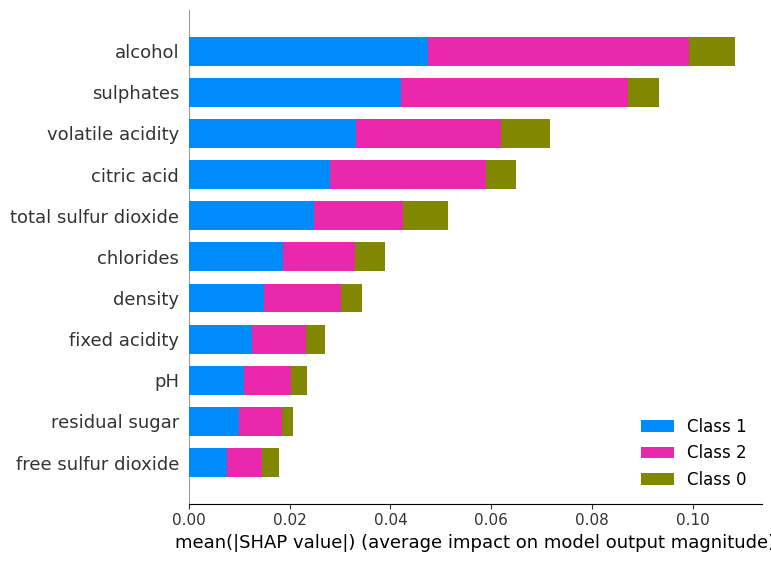

In [46]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_scaled, approximate=False, check_additivity=False)
shap.summary_plot(shap_values, X_train)

In [ ]:
ABS_SHAP(shap_values,X_train_scaled)